## Deep Learning Assignment 1

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.
This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

/Users/wangwei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


- train_filename = maybe_download('notMNIST_large.tar.gz',247336696)
- train_folders = maybe_extract(train_filename)
- train_picklenames = maybe_pickle(train_folders, 45000)
- v_dataset, v_labels, tr_dataset, tr_labels = merge_datasets(train_picklenames, train_size, valid_size)
- train_dataset, train_labels = randomize(tr_dataset, tr_labels)


### First, we'll download the dataset to our local machine. 
The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.


In [2]:
# 第一个模块，需要知道的参数是： url， 压缩文件名：notMNIST.tar.gz
# 功能是将 url上的gz文件下载下来，下载的地址在哪里，我不知道
# 输出的是下载文件名notMNIST.tar.gz，以及下载好的文件
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 25 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        
        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, filename, reporthook = download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

train_filename = maybe_download('notMNIST_large.tar.gz',247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


## Then, extract the dataset from the .tar.gz file. 
This should give you a set of directories, labelled A through J.


In [3]:
# 第二个模块， 需要知道的参数是： 从url下载的压缩文件名
# 常数参数是： num_classes, seed
# root ： notMNIST_large
# 功能是将 gz 文件解压缩，实际上解压缩后的文件夹 notMNIST_large/ 下有10个子文件夹
# /A /B... /J
# data_folders是将所有子文件夹的路径放在一起, e.g.,[notMNIST_large/A, notMNIST_large/B]
# 输出就是子文件夹路径的集合： data_folders
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force = False):
    # remove .tar.gz
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force:
        # You may override by setting force=True
        print("%s already present - Skipping extraction of %s." 
              % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.'
              % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
           'Expected %d folders, one per class. Found %d instead.' 
            %(num_class, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


## Problem 1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

In [4]:
root = 'notMNIST_large/A'
print(os.listdir(root)[0])
image_names = [
        os.path.join(root, d) for d in os.listdir(root)]
for imageName in image_names[:10]:
    display(Image(filename=imageName))

a29ydW5pc2hpLnR0Zg==.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, 
- we'll load each class into a separate dataset, 
- store them on disk and curate them independently,
- later we'll merge them into a single dataset of manageable size.
We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
A few images might not be readable, we'll just skip them.

In [5]:
# 第三个模块，需要的参数是：data_folders
# 常数参数： image_size, pixel_depth
# 功能是将每一个子文件夹的image都转化为文件保存在磁盘上一个新文件，比如 
#       notMNIST_large/A.pickle,
# 调用一个子模块：load_letter，功能是 读入一个子文件夹里面num_images 个image files
# 比如 notMNIST_large/A
# 输出是一个 3维矩阵 dataset,size 是num_images * 28 * 28
# 第三个模块会把dataset 进行持久化，用 pickle 函数
# 这个模块的输出是dataset_names : 所有子文件夹新的picklename的集合，比如
# [notMNIST_large/A.pickle, notMNIST_large/B.pickle,...]
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):  
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names

train_picklenames = maybe_pickle(train_folders, 45000)
test_picklenames = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

## Problem 2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

The shape of each pickle file is : (52912, 28, 28)


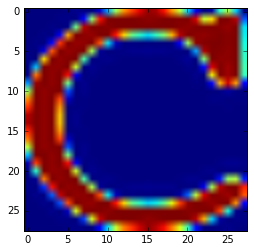

In [6]:
# load one pickle and check what we can find
obj2 = pickle.load(open('notMNIST_large/C.pickle', 'r'))
print('The shape of each pickle file is :', obj2.shape)
sampleBimage = obj2[1111]
plt.imshow(sampleBimage)

## Problem 3
Another check: we expect the data to be balanced across classes. Verify that.
__________________________________________________________________

In [7]:
a = np.zeros(10)

for label, picklename in enumerate(train_picklenames):
    obj2 = pickle.load(open(picklename, 'r'))
    print('The num of images in %s is : %d' % (picklename, obj2.shape[0]) )
    a[label]=obj2.shape[0]

print('The std of the num of images is ', np.std(a),'.')

for label, picklename in enumerate(test_picklenames):
    obj2 = pickle.load(open(picklename, 'r'))
    print('The num of images in %s is : %d' % (picklename, obj2.shape[0]) )
    a[label]=obj2.shape[0]

The num of images in notMNIST_large/A.pickle is : 52909
The num of images in notMNIST_large/B.pickle is : 52911
The num of images in notMNIST_large/C.pickle is : 52912
The num of images in notMNIST_large/D.pickle is : 52911
The num of images in notMNIST_large/E.pickle is : 52912
The num of images in notMNIST_large/F.pickle is : 52912
The num of images in notMNIST_large/G.pickle is : 52912
The num of images in notMNIST_large/H.pickle is : 52912
The num of images in notMNIST_large/I.pickle is : 52912
The num of images in notMNIST_large/J.pickle is : 52911
The std of the num of images is  0.916515138991 .
The num of images in notMNIST_small/A.pickle is : 1872
The num of images in notMNIST_small/B.pickle is : 1873
The num of images in notMNIST_small/C.pickle is : 1873
The num of images in notMNIST_small/D.pickle is : 1873
The num of images in notMNIST_small/E.pickle is : 1873
The num of images in notMNIST_small/F.pickle is : 1872
The num of images in notMNIST_small/G.pickle is : 1872
The n

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.
Also create a validation dataset for hyperparameter tuning.


In [8]:
# 初始化一个array， size是 nrows * img_size * img_size
def make_array(nb_rows, img_size):
    labels = None
    if nb_rows:
        dataset = np.ndarray((nb_rows,img_size, img_size), dtype = np.float32)
        labels = np.ndarray(nb_rows,dtype=np.int32)
    else:
        dataset = None
    return dataset, labels
# 第四个模块，输入参数是 pickle_files, train/test数据集的行数， valids数据集的行数
# 功能是：从每一个pickle file重新读出 行数*28*28 的image集合，shuffle一下，
#        给到training 或者validation，
# 输出：train_dataset, train_label, valid_dataset, valid_label
# 注意： 此时的lable都是 [00000...11111....22222]
def merge_datasets(pickle_files, train_size, valid_size):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_array(valid_size,image_size)
    train_dataset, train_labels = make_array(train_size,image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class

    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file,'rb') as f:
                letter_set = pickle.load(f)
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class,:,:]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :,:] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    return valid_dataset, valid_labels, train_dataset, train_labels


    
train_size = 200000
valid_size = 10000
test_size = 10000

v_set, v_labels, tr_set, tr_labels = merge_datasets(train_picklenames, train_size, valid_size)
_, _, te_set, te_labels = merge_datasets(test_picklenames, test_size, False)

print('Training:', tr_set.shape, tr_labels.shape)
print('Validation:', v_set.shape, v_labels.shape)
print('Testing:', te_set.shape, te_labels.shape)


Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.


In [9]:
def randomize(dataset,labels):
    #np.random.permutation(9): array([0, 7, 3, 2, 6, 8, 1, 4, 5])
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(tr_set, tr_labels)
test_dataset, test_labels = randomize(te_set, te_labels)
valid_dataset, valid_labels = randomize(v_set, v_labels)


In [10]:
# Finally, let's save the originaldata for later reuse:
pickle_file = 'notMNIST_original.pickle'

try:
    f = open(pickle_file,'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    del save  # hint to help gc free up memory
except Exception as e:
    print('Unable to save data to', pickle_file, ":", e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)
    

Compressed pickle size: 690798592


## Problem 4
Convince yourself that the data is still good after shuffling!

array([9, 3, 6, ..., 3, 6, 4], dtype=int32)

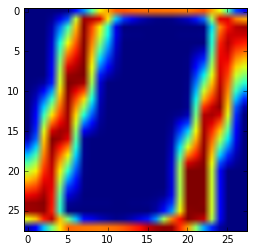

In [203]:
plt.imshow(train_dataset[38,:,:])
train_labels

## Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. 

- Measure how much overlap there is between training, validation and test samples.
Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [154]:
import time
def fast_overlaps_num_set_and_hash(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    hash1 = set([hash(image1.data) for image1 in images1])
    hash2 = set([hash(image2.data) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return len(all_overlaps)
def find_dups_and_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    dup_table={}
    duplicates1 = []
    for idx,img in enumerate(images1):
        h = hash(img.data)
        if h in dup_table and (images1[dup_table[h]].data == img.data):
            duplicates1.append((idx, dup_table[h]))
            #print 'Duplicate image: %d matches %d' % (idx, dup_table[h])
        dup_table[h] = idx
    overlaps = []
    for idx,img in enumerate(images2):
        h = hash(img.data)
        if h in dup_table and (images1[dup_table[h]].data == img.data):
            overlaps.append((dup_table[h], idx))
            #print 'Test image %d is in the training set' % idx
    return duplicates1, overlaps
def num_overlaps_with_diff_labels(overlap_indices, labels1, labels2):
    count = 0
    for olap in overlap_indices:
        if labels1[olap[0]] != labels2[olap[1]]:
            count += 1
    return count
def hashlib_set():
    train_dataset_map, valid_dataset_map, test_dataset_map = set(), set(), set()

    for img_data in train_dataset:
        train_dataset_map.add(sha1(img_data).hexdigest())
    for img_data in valid_dataset:
        valid_dataset_map.add(sha1(img_data).hexdigest())
    for img_data in test_dataset:
        test_dataset_map.add(sha1(img_data).hexdigest())

    inter_tr_v = train_dataset_map.intersection(valid_dataset_map)
    inter_tr_t = train_dataset_map.intersection(test_dataset_map)
    inter_v_t = valid_dataset_map.intersection(test_dataset_map)

    print("inter_tr_v = ", len(inter_tr_v))
    print("inter_tr_t = ", len(inter_tr_t))
    print("inter_v_t = ", len(inter_v_t))
def faster_overlaps_hashlib_and_numpy():
    import hashlib
    train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
    valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
    test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

    valid_in_train = np.in1d(valid_hashes, train_hashes)
    test_in_train  = np.in1d(test_hashes,  train_hashes)
    test_in_valid  = np.in1d(test_hashes,  valid_hashes)
    
    train_in_valid = np.in1d(train_hashes, valid_hashes)
    train_in_test  = np.in1d(train_hashes,test_hashes)
    valid_in_test  = np.in1d(valid_hashes,test_hashes)

    valid_keep = ~valid_in_train
    test_keep  = ~(test_in_train | test_in_valid)

    valid_dataset_clean = valid_dataset[valid_keep]
    valid_labels_clean  = valid_labels [valid_keep]

    test_dataset_clean = test_dataset[test_keep]
    test_labels_clean  = test_labels [test_keep]

    print("valid -> train overlap: %d samples" % valid_in_train.sum())
    print("test  -> train overlap: %d samples" % test_in_train.sum())
    print("test  -> valid overlap: %d samples" % test_in_valid.sum())
    
    print("inter_tr_v = " , train_in_valid.sum())
    print("inter_tr_t = " , train_in_test.sum())
    print("inter_v_t = " , valid_in_test.sum())

print('\nMethod 1: hash and check equality')
t1 = time.time()
train_dups, train_valid_overlaps = find_dups_and_overlaps(train_dataset, valid_dataset)
test_dups, test_train_overlaps = find_dups_and_overlaps(test_dataset, train_dataset)
valid_dups, valid_test_overlaps = find_dups_and_overlaps(valid_dataset, test_dataset)
print('train dups: %s, test_dups: %s, valid_dups: %s' % (len(train_dups), len(test_dups), len(valid_dups)))
print('train/valid overlaps: %s, of which %s have different labels' % \
       (len(train_valid_overlaps), num_overlaps_with_diff_labels(train_valid_overlaps, train_labels, valid_labels)))
print('test/train overlaps: %s, of which %s have different labels' % \
        (len(test_train_overlaps), num_overlaps_with_diff_labels(test_train_overlaps, test_labels, train_labels)))
print('valid/test overlaps: %s, of which %s have different labels' % \
        (len(valid_test_overlaps), num_overlaps_with_diff_labels(valid_test_overlaps, valid_labels, test_labels)))
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))

print('\nMethod 2: hash and set')
t1 = time.time()
print('fast train/validation overlaps: %s ' % fast_overlaps_num_set_and_hash(train_dataset, valid_dataset))
print('fast train/test overlaps: %s' % fast_overlaps_num_set_and_hash(train_dataset, test_dataset))
print('fast test/validation overlaps: %s' % fast_overlaps_num_set_and_hash(test_dataset, valid_dataset))
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))

print('\nMethod 3: hashlib and set')
t1 = time.time()
hashlib_set()
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))
print('\nMethod 4: hashlib and numpy')
t1 = time.time()
faster_overlaps_hashlib_and_numpy()
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))


Method 1: hash and check equality
train dups: 12783, test_dups: 142, valid_dups: 128
train/valid overlaps: 1067, of which 39 have different labels
test/train overlaps: 7324, of which 288 have different labels
valid/test overlaps: 349, of which 10 have different labels
Time: 2.06s

Method 2: hash and set
fast train/validation overlaps: 953 
fast train/test overlaps: 4293
fast test/validation overlaps: 230
Time: 2.00s

Method 3: hashlib and set
inter_tr_v =  953
inter_tr_t =  4293
inter_v_t =  230
Time: 1.25s

Method 4: hashlib and numpy
valid -> train overlap: 1067 samples
test  -> train overlap: 4426 samples
test  -> valid overlap: 349 samples
inter_tr_v =  3627
inter_tr_t =  7324
inter_v_t =  336
Time: 1.43s


In [11]:
def hashlib_and_numpy():
    import hashlib
    train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
    valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
    test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

    valid_in_train = np.in1d(valid_hashes, train_hashes)
    test_in_train  = np.in1d(test_hashes,  train_hashes)
    test_in_valid  = np.in1d(test_hashes,  valid_hashes)

    valid_keep = ~valid_in_train
    test_keep  = ~(test_in_train | test_in_valid)

    valid_dataset_clean = valid_dataset[valid_keep]
    valid_labels_clean  = np.squeeze(valid_labels [valid_keep])

    test_dataset_clean = test_dataset[test_keep]
    test_labels_clean  = np.squeeze(test_labels [test_keep])

    print("valid -> train overlap: %d samples" % valid_in_train.sum())
    print("test  -> train overlap: %d samples" % test_in_train.sum())
    print("test  -> valid overlap: %d samples" % test_in_valid.sum())
    
    return valid_dataset_clean, valid_labels_clean, test_dataset_clean, test_labels_clean
valid_dataset, valid_labels, test_dataset, test_labels=hashlib_and_numpy()
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

valid -> train overlap: 1067 samples
test  -> train overlap: 1324 samples
test  -> valid overlap: 200 samples
Training set (200000, 28, 28) (200000,)
Validation set (8933, 28, 28) (8933,)
Test set (8639, 28, 28) (8639,)


In [191]:
def remove_dups_in1set(images,labels):
    images.flags.writeable=False
    dup_table={}
    keep = []
    for idx,img in enumerate(images):
        h = hash(img.data)
        if h in dup_table and (images[dup_table[h]].data == img.data):
            keep.append(False)
        else:
            dup_table[h] = idx
            keep.append(True)
    keep = np.asarray(keep)

    images_keep = images[keep]
    labels_keep = np.squeeze(labels[keep])
    print('duplicates are :',images.shape[0]-images_keep.shape[0])
    return images_keep, labels_keep
test_dataset, test_labels = remove_dups_in1set(test_dataset,test_labels)
train_dataset, train_labels = remove_dups_in1set(train_dataset,train_labels)
valid_dataset, valid_labels = remove_dups_in1set(valid_dataset,valid_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

duplicates are : 8
duplicates are : 12783
duplicates are : 14


In [13]:
# Finally, let's savethe data for later reuse:
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file,'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    del save  # hint to help gc free up memory
except Exception as e:
    print('Unable to save data to', pickle_file, ":", e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)
    

Compressed pickle size: 683176521


## Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.
Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.
Optional question: train an off-the-shelf model on all the data!

In [79]:
from sklearn.linear_model import LogisticRegression
try:
    with open(pickle_file,'rb') as f:
        pickle_dict = pickle.load(f)
               
except Exception as e:
    print('Unable to process data from', pickle_file, ':', e)
    raise

In [80]:
X_tr = pickle_dict['train_dataset']
y_tr = pickle_dict['train_labels']
X_va = pickle_dict['valid_dataset']
y_va = pickle_dict['valid_labels']
X_te = pickle_dict['test_dataset']
y_te = pickle_dict['test_labels']

In [81]:
#n_features = 
X_trvec = X_tr.reshape(X_tr.shape[0],X_tr.shape[1]*X_tr.shape[1])
X_vavec = X_va.reshape(X_va.shape[0],X_va.shape[1]*X_va.shape[1])
X_tevec = X_te.reshape(X_te.shape[0],X_te.shape[1]*X_te.shape[1])


In [82]:
C = 1.0
Classifier = LogisticRegression(C=C, penalty='l1')


In [84]:
y_tr

array([3, 5, 4, ..., 8, 9, 6], dtype=int32)

In [85]:
Classifier.fit(X_trvec, y_tr)
y_pred = Classifier.predict(X_trvec)
classif_rate = np.mean(y_pred.ravel() == y_tr.ravel()) * 100
print("classif_rate : %f " % classif_rate)

classif_rate : 83.125000 
